# Assignment 1 - LeNet
*This notebook was run by Arsyi Syarief Aziz (H071191003) for the Introduction to Deep Learning course (Unhas) taught by Risman Adnan.*



In this assignment, I will attempt to recreate the LeNet CNN architecture, similar to what Yann LeCun introduced in 1998 (with some modifications), to classify numbers found in the MNIST dataset.

The original LeNet (LeNet-5) architecture consists of two parts: 
1. a convolutional encoder consisting of two convolutional layers (which uses a 5x5 kernel and the scaled hyperbolic tangent activation function) and two average pooling layers, and
2. a dense block consisting of three fully-connected layers with the scaled hyperbolic tangent activation function.

The architecture is visualized in the figure below
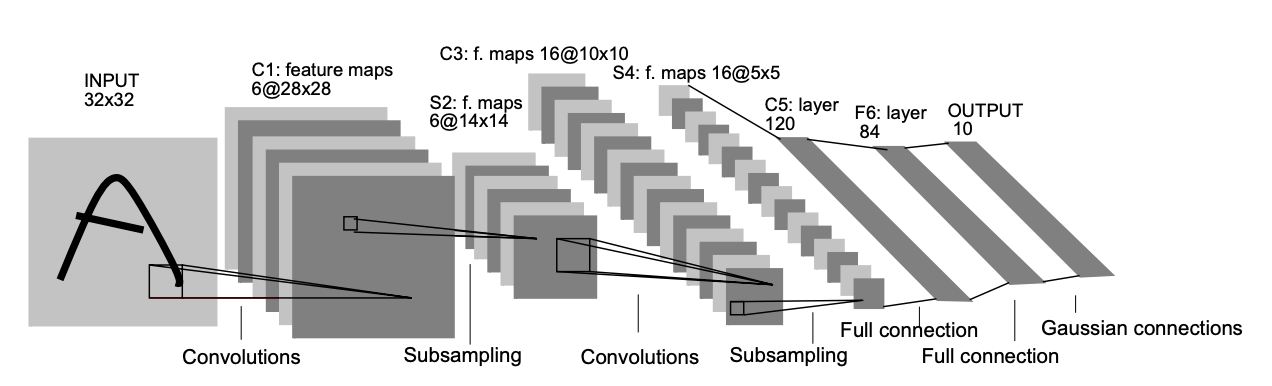

However, due to the implementation complexity of the original architecture, I will implement D2L's version of LeNet, which uses the sigmoid activation function and no gaussian activation function at the final layer.

This implementation is visualized in the figure below
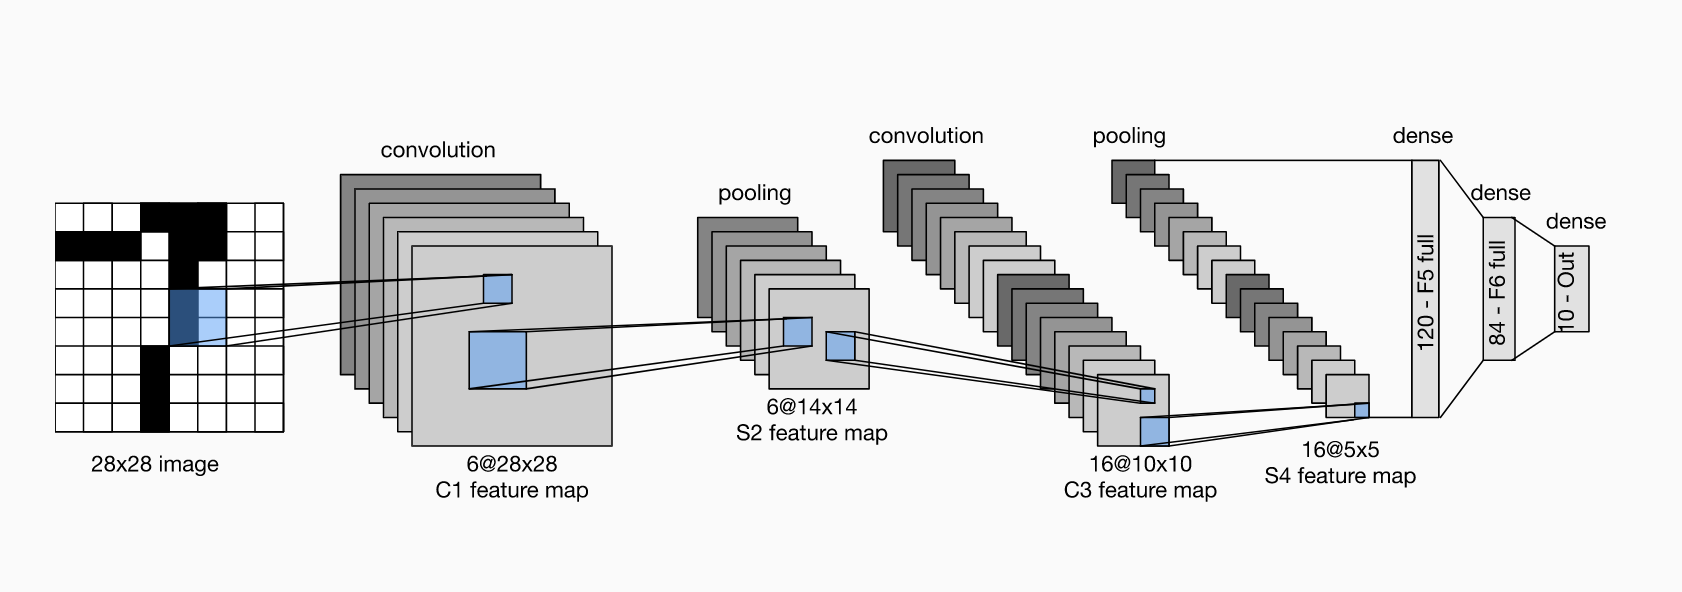

## Implementation

In [1]:
import torch
from torch import nn

In [2]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10),
)

In [3]:
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.transforms as transforms

In [4]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1.0,))])

In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=trans)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=trans)

In [6]:
print(len(mnist_trainset), len(mnist_testset))

60000 10000


In [7]:
batch_size = 256

In [8]:
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False)

In [9]:
def train(net, train_iter, test_iter, num_epochs, lr):    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
            
    net.apply(init_weights)
        
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
        print(f'Epoch: {epoch + 1}')
            

In [10]:
lr, num_epochs = 0.9, 10
train(net, train_loader, test_loader, num_epochs, lr)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


## Testing

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

Ex 0:
Prediction: 7
Actual: 7


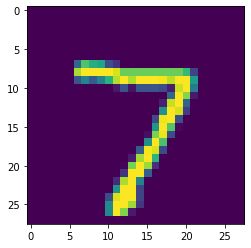

Ex 1:
Prediction: 2
Actual: 2


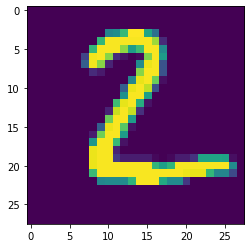

Ex 2:
Prediction: 1
Actual: 1


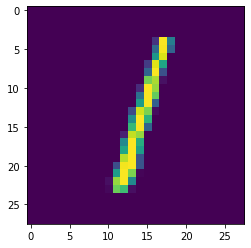

Ex 3:
Prediction: 0
Actual: 0


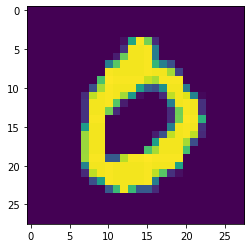

Ex 4:
Prediction: 4
Actual: 4


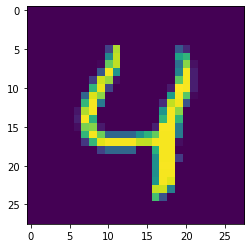

Ex 5:
Prediction: 1
Actual: 1


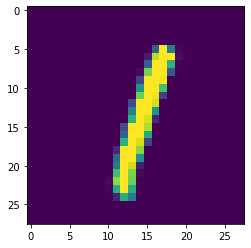

Done!


In [12]:
correct = 0
total = 0

number_of_ex_to_show = 5
num_ex_shown = 0
iterables = iter(test_loader)
try:
    while data := next(iterables):
        (X_test, y_test) = data
        for i, (x, y) in enumerate(zip(X_test, y_test)):
            y_hat = net(x.reshape(1, 1, 28, 28)).argmax()
            if num_ex_shown <= (number_of_ex_to_show):
                print(f'Ex {i}:')
                print(f'Prediction: {y_hat}')
                print(f'Actual: {y}')
                im = x.reshape(28, 28, 1)
                plt.imshow(im)
                plt.show()
            if y_hat == y:
                correct += 1
            total +=1
            num_ex_shown += 1
except StopIteration:
    print('Done!')

## Results

In [14]:
print(f"Accuracy: {(correct/total)*100}% ({correct}/{total})")

Accuracy: 96.7% (9670/10000)


The model predicted 96.7% (9670/10000) of the test set correctly. 